# Remote Sensing

<a id="display"></a>
## Image display

A digital image is a 2D array of numbers in lines and columns or a raster dataset. It can also have a third dimension, in the form of other layers. Each cell of a digital image is called a pixel and the number representing the brightness of the pixel is called a **digital number (DN).** It can be composed of any number of layers/bands.
<img src="Data_Image_Operations/Image_Layers.png" style="width:40%"/>

Not all bands are within the visible spectrum, however we can visualise them by assigning them to a colour gun in the visible spectrum. Following **tristimulus colour theory**, human colour perception is performed by three types of cones matching three primary colour: **R**ed, **G**reen and **B**lue (RGB). the combination of these three colours:
$$ C=rR+gG+bB $$
Allows any colour to be represented within the visible spectrum.

Introducing some common terminology:

** True colour composite ** -> display of 3 image bands in red, green and blue spectral ranges matching RGB. 

** False colour composite ** -> bands displayed in red, green and blue do not match the spectra of these three primary colours

** Pseudo colour display ** -> displays a monochrome image as a colour image by assigning each grey level to a unique colour. This benefits visualisation as our eyes perceive more colours than grey levels however the original quantitative sequential relationships of the DNs are lost. 

In [ ]:
# Import required packages
!pip install --upgrade pip
!pip install opencv-python

In [86]:
# Import required libaries
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import cv2

Image dimension = (899, 1600, 4)


(<matplotlib.image.AxesImage at 0x7f99c6edeef0>, None)

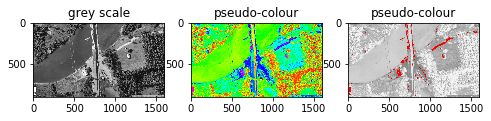

In [340]:
#read in image
img = imageio.imread('Data_Image_Operations/Picture1.png')

#find out image ratio
print('Image dimension =', img.shape) 

#separate layers
image0 = np.uint8(img[:,:,0])
image1 = np.uint8(img[:,:,1])
image2 = np.uint8(img[:,:,2]) 

#plot grey scale
fig = plt.figure()
fig.add_subplot(231), plt.title('grey scale')
plt.imshow(image0, cmap = 'gray'), plt.gcf().set_size_inches(8, 11)

#plot pseudo colour display
fig.add_subplot(232), plt.title('pseudo-colour')
plt.imshow(image0, cmap = 'gist_rainbow'),
plt.gcf().set_size_inches(8, 11)

#generate colourbar to highlight brightest DNs (see reference 1)
threshold = 0.8 
colors = [(0, "white"),
    (threshold*float(np.max(image0))/float(np.max(image0)), "gray"),
    (threshold*float(np.max(image0))/float(np.max(image0)), "red"), 
          (1, "red") ]
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', 
                                                   colors)

#generate plot using new colourbar
fig.add_subplot(233), plt.title('pseudo-colour'),
plt.imshow(image0,cmap=mycmap), plt.gcf().set_size_inches(8, 11)


<a id="point_operation"></a>
## Point operations
A point operation is a modification of a pixel value which is based on that pixel value and is independent of location or neighboring values. If we let x represent a digital image and $x_{i,j}$ is the DN of any pixel and Y the output pixel of any image then we describe any point operations as:
$$y_{i,j}=f(x_{i,j}) $$
This is also frequently called histogram modification as it only alters the histogram of an image but not spatial relationship of image pixels.  Since our result is irrespective of its spatial location we will always have the same output for a specific input. This allows a **LookUp Table (LUT)** to be used. All values are computed first for every present DN level and the inputs are simply matched to their corresponding output. This saves computational time by not repeating the same operation. 

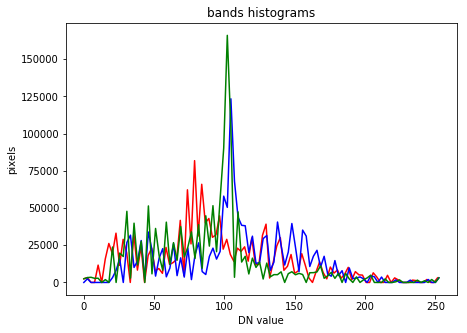

In [341]:
#Create histograms for all 3 bands

histogram0, bin_edges0 = np.histogram(image0, bins=100, range=(0, 
                                                np.max(image0)))
histogram1, bin_edges1 = np.histogram(image1, bins=100, range=(0, 
                                                np.max(image1)))
histogram2, bin_edges2 = np.histogram(image2, bins=100, range=(0, 
                                                np.max(image2)))

#create figure
plt.figure()
plt.title("bands histograms")
plt.xlabel("DN value")
plt.ylabel("pixels")

#plot histograms
plt.plot(bin_edges0[0:-1], histogram0, 'r')
plt.plot(bin_edges1[0:-1], histogram1, 'b')
plt.plot(bin_edges2[0:-1], histogram2, 'g')
plt.gcf().set_size_inches(7, 5)
plt.show()

<a id="clip"></a>
### cut-off clipping

In digital images a few pixels (often noise) can occupy wide value ranges at the low and high ends of the histograms, in the example above this ican be seen at the high end. In this case we can cut-off these pixels to later make better use of the dynamic range of our display (commonly 8-bit).

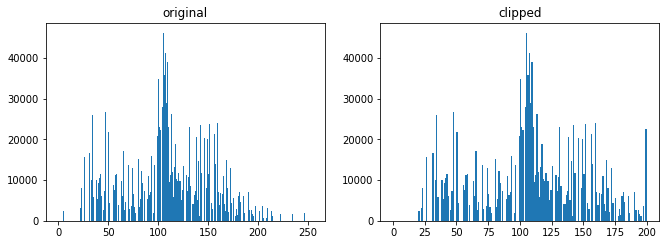

In [342]:
#set cut-off limits
image1_clip = np.clip(image1, 20, 200)
#can always clip top and bottom 1% of pixels in histogram as a standard
#range

#visualise change
fig = plt.figure()

fig.add_subplot(221), plt.title('original'), 
plt.hist(image1.ravel(),np.max(image0),[0,np.max(image0)]),
plt.gcf().set_size_inches(11, 8)

fig.add_subplot(222), plt.title('clipped')
plt.hist(image1_clip.ravel(),np.max(image1_clip),[0,np.max(image1_clip)]), 
plt.gcf().set_size_inches(11, 8)

plt.show()

<a id="contrast"></a>
### Contrast enhancement
Is the most basic but most effective and efficient technique to optimise the image contrast and brightness for visualisation or to highlight information in particular DN ranges.

**Linear Contrast Enhancement (LCE)** is the simplest and one of the most effective contrast enhancement techniques. In this function, **a** controls the contrast of the output image, and **b** modifies the overall brightness. 
$$ y = ax + b $$
- if a > 1, stretching function which increase the image contrast
- if a <1 but positive, compressional function which decreases the image contrast

This function effect can be visualised as follows:

<img src="Data_Image_Operations/Contrast_Enhancement.png" style="width:30%"/>

LCE improves image contrast without distorting the image information if the output DN range is wider than the input DN range. There are several methods to apply this:
- **interactive linear stretch** - changing a and b interactively allows for optimization based on users visual judgement
- **linear scale** - automatically scale the DN range to the full dynamics range of the display
- **piecewise linear stretch** - apply several different linear functions to different ranges. Can be used to simulate very complex non-linear functions. 

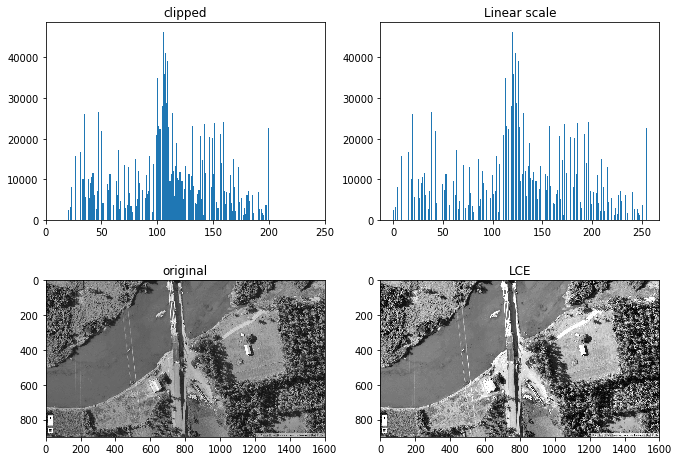

an increase in contrast can be seen


In [343]:
#save time by by only computing values once
MIN = np.min(image1_clip)
MAX = np.max(image1_clip)

#apply linear scale
LCE = (image1_clip-MIN)*(255/(MAX-MIN))

#Could be done using a lookup table, unhash "##" to use
##LUT  = {}
##for i in range(MIN,MAX+1): LUT[i] = (i-MIN)*(255/(MAX-MIN))   
##LCE = np.array([LUT.get(i) for i in range(MIN, MAX + 1)])
##LCE = indexer[(image1_clip - MIN)]


#compare results
fig = plt.figure()

fig.add_subplot(221), plt.title('clipped'), plt.xlim(0,250)
plt.hist(image1_clip.ravel(),np.max(image1_clip),
    [0,np.max(image1_clip)]), plt.gcf().set_size_inches(11, 8)

fig.add_subplot(222), plt.title('stretched (LCE)')
plt.hist(LCE.ravel(),np.max(image1),[0,np.max(image1)]),
plt.gcf().set_size_inches(11, 8)

fig.add_subplot(224), plt.title('streched (LCE)'), plt.set_cmap('gray')
plt.imshow(LCE), plt.gcf().set_size_inches(11, 8)

fig.add_subplot(223), plt.title('original'), plt.set_cmap('gray')
plt.imshow(image1), plt.gcf().set_size_inches(11, 8)

plt.show()

print ('an increase in contrast can be seen')

(<matplotlib.image.AxesImage at 0x7f99c6eafa20>, None)

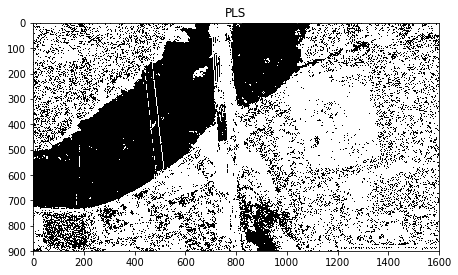

In [338]:
#copy array and make sure values are int
PLS = LCE.copy().astype(int)
MIN = int(np.min(PLS))
MAX = int(np.max(PLS))

#create dictionary
d  = {}
for i in range(MIN,MAX+1):  
    if 100<i<150:
        d[i] = 0
    else:
        d[i]=1

#apply dictionary to image
PLS_ = PLS.flatten()
out = np.array([d.get(i) for i in PLS_])
out = out.reshape(PLS.shape[0],PLS.shape[1])

#visuale result
fig = plt.figure()
fig.add_subplot(221), plt.title('PLS'), plt.set_cmap('gray')
plt.imshow(out), plt.gcf().set_size_inches(16, 22)

We have removed the peak in the blue spectral layer which is dominantly water in our image. Within this part of the spectrum it is difficult to remove water only. Higher frequency bands like NIR or SWIR make it much easier to isolate water from our image as it has a clear separation from the rest of the objects in those bands. This is a great application when trying to use the optimal DN range on land or to identify coastlines.

Further reading on implementing piecewise functions: [link](http://yetanothermathprogrammingconsultant.blogspot.com/2019/02/piecewise-linear-functions-and.html)

### Balance Contrast Enhancement Technique (BCET)$^2$

Colour bias is one of the major causes of poor colour composite images. To eliminate bias, the three input bands used for colour composition must have an equal value range and mean. BCET is an elegant solution to this problem. It can stretch or compress the image to a given value range and mean without changing the basic shape of the image histogram, hence not distorting the image information, using a parabolic (or cubic) function which is based on the min, max and mean of each input band and is nearly linear over this value/display range.

<img src="Data_Image_Operations/BCET1.png" style="width:70%"/>

Lastly, BCET also acts as an effective normalisation of the common information among the bands. By ensuring that each band occupies the same mean and value range, the common information is suppressed and the unique spectral variation between them is revealed.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in ubyte_scalars


(<matplotlib.image.AxesImage at 0x7f99cab50f98>, None)

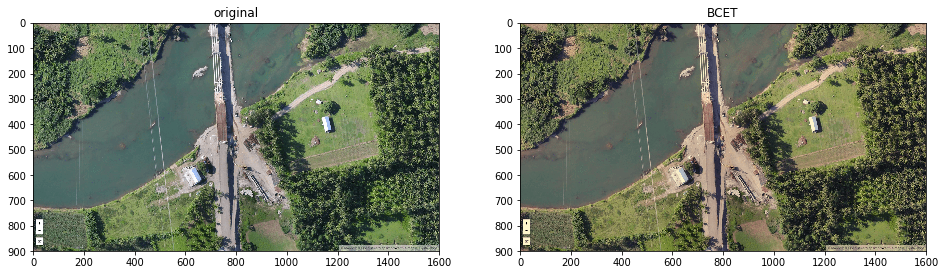

In [141]:
#define BCET function
def BCET (img):
    l= np.min(img)
    h= np.max(img)
    e= np.mean(img)
    L = 0
    H = 255 #use full dynamic range
    E = 110 #can be varied
    s = np.mean(img^2)
    b = (h**2 *(E-L)-s*(H-L)+l**2 *(H-E)) / (2*(h*(E-L)-e*(H-L)+l*(H-E)))
    a = (H-L)/((h-l)*(h+l-2*b))
    c = L-a*(l-b)**2
    y = a*(img-b)**2 +c
    return y.astype(int) #ensure all integers to plot image

#apply function
image_BCET0 = BCET(image0)
image_BCET1 = BCET(image1)
image_BCET2 = BCET(image2)

#stack 3 bands back together
rgb = np.dstack((image_BCET0,image_BCET1,image_BCET2))

#visualise results
fig = plt.figure()
fig.add_subplot(221), plt.title('original'), plt.set_cmap('gray')
plt.imshow(img), plt.gcf().set_size_inches(16, 22)

fig.add_subplot(222), plt.title('BCET'), plt.set_cmap('gray')
plt.imshow(rgb), plt.gcf().set_size_inches(16, 22)

You can see the blue look of the original image has disappeared. To visualise the results graphically see the histograms below.

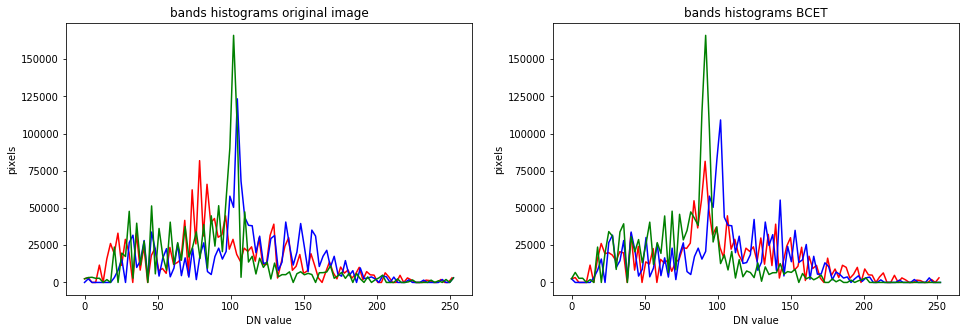

In [344]:
histogram_BCET0, bin_edges0 = np.histogram(image_BCET0, bins=100, 
                                        range=(0, np.max(image0)))
histogram_BCET1, bin_edges1 = np.histogram(image_BCET1, bins=100, 
                                        range=(0, np.max(image1)))
histogram_BCET2, bin_edges2 = np.histogram(image_BCET2, bins=100, 
                                        range=(0, np.max(image2)))

fig = plt.figure()
fig.add_subplot(222), plt.title("bands histograms after BCET")
plt.xlabel("DN value"), plt.ylabel("pixels")
#plot histograms
plt.plot(bin_edges0[0:-1], histogram_BCET0, 'r')
plt.plot(bin_edges1[0:-1], histogram_BCET1, 'b')
plt.plot(bin_edges2[0:-1], histogram_BCET2, 'g')
plt.gcf().set_size_inches(16, 11)

fig.add_subplot(221), plt.title("bands histograms original image")
plt.xlabel("DN value"), plt.ylabel("pixels")
#plot histograms
plt.plot(bin_edges0[0:-1], histogram0, 'r')
plt.plot(bin_edges1[0:-1], histogram1, 'b')
plt.plot(bin_edges2[0:-1], histogram2, 'g')
plt.gcf().set_size_inches(16, 11)
plt.show()

The peaks have been shifted to occupy the same range and mean of the overall histogram. 


<a id="rules"></a>
### Golden rules for good contrast enhancement
- After any processing that changes the DN value range of an image, you will still need to apply contrast enhancement to view the results properly
- Visual observation is best to judge image quality
- Before extracting spectral profiles the data should be well stretched, ideally using BCET (or, failing that, using a simple linear function)


<a id="references_"></a>
## References
Theory, content structure and images have been obtained from module thought content: J Mason, P., n.d. ESE 3.25 Advanced Remote Sensing. pp.3 - 12.

1. Stack Overflow. 2020. Define A Colormap For Each Set Of Values In An Array. [online] Available at: <https://stackoverflow.com/questions/42605051/define-a-colormap-for-each-set-of-values-in-an-array> [Accessed 22 June 2020].
2. GUO, L., 1991. Balance contrast enhancement technique and its application in image colour composition. International Journal of Remote Sensing, 12(10), pp.2133-2151.

    

    